In [1]:
# to access functions from root directory
import sys
sys.path.append('/data/ad181/RemoteDir/multilevel_ppo')

In [2]:
%matplotlib notebook
import numpy as np
import time
import matplotlib.pyplot as plt
import pickle
import os
from copy import deepcopy

from stable_baselines3.ppo import PPO
from stable_baselines3.ppo_multi_level import PPO_ML
from utils.plot_functions import plot_rl, plot_k_array, plot_learning_tr, plot_actions, plot_rewards
from utils.env_evaluate_functions import eval_actions, eval_model
from utils.data_handling import get_mean_tr_data, get_sar_data, get_min_tr_data, get_max_tr_data

In [3]:
case='case_1'
seed=1

ppo_1l_dir ='../ppo_multilevel/data/ppo_1l'
ppo_2l_dir = '../ppo_multilevel/data/ppo_2l'
ppo_3l_dir = '../ppo_multilevel/data/ppo_3l'
mlmc_analysis_dir = '../ppo_multilevel/data/mlmc_analysis'
opt_dir = '../de/case_1'

data_dir = './'+case
os.makedirs(data_dir, exist_ok=True)

In [4]:
# convert the heavy model PPO to PPO_light
# analysis_model = PPO_ML.load(mlmc_analysis_dir+'/seed_'+str(seed)+'/PPO')
# analysis_model.analysis_rollout_buffer_dict = {}
# analysis_model.sync_rollout_buffer_dict = {}
# analysis_model.rollout_buffer_dict = {}
# analysis_model.sync_rollout_buffer_dict = {}
# analysis_model.save(mlmc_analysis_dir+'/seed_'+str(seed)+'/PPO_light')

# MLMC analysis data

In [5]:
analysis_model = PPO_ML.load(mlmc_analysis_dir+'/seed_'+str(seed)+'/PPO_light')

print('PPO parameters')
print(f'number of actors: {analysis_model.n_envs}')
print(f'number of steps: {analysis_model.n_steps_dict}')
print(f'minibatchsize: {analysis_model.batch_size_dict}')
print(f'number of epochs: {analysis_model.n_epochs}')

print('\n MLMC analysis data')
for key in analysis_model.analysis_report.keys():
    print(key)
    for key_ in analysis_model.analysis_report[key].keys():
        print(f'\t{key_}')
        for _key_ in analysis_model.analysis_report[key][key_].keys():
            print(f'\t\t{_key_}: {analysis_model.analysis_report[key][key_][_key_]}')

PPO parameters
number of actors: 50
number of steps: {'1': 50, '2': 50, '3': 50}
minibatchsize: {'1': 250, '2': 250, '3': 250}
number of epochs: 20

 MLMC analysis data
iter 30
	expt_results
		N: 100000
		C_l: [0.06, 0.15, 1.0]
		V_l: [1.0, 1.0, 1.0]
		P_l: [-0.0835, -0.0826, -0.0817]
	mc_results
		eps_mc: [0.1        0.03162278 0.01      ]
		P_mc: [-0.0352, -0.0462, -0.076]
		N_mc: [200, 1997, 19963]
		C_mc: 1.0
		V_mc: 1.0
	ml_results
		eps_ml: [0.1        0.03162278 0.01      ]
		P_ml: [-0.1093, -0.0744, -0.0779]
		N_ml: [[382, 31, 13], [3815, 302, 126], [38141, 3011, 1252]]
		C_ml: [[0.06, 0.21, 1.15], [0.06, 0.21, 1.15], [0.06, 0.21, 1.15]]
		V_ml: [[1.0, 0.02, 0.02], [1.0, 0.02, 0.02], [1.0, 0.02, 0.02]]
		a,b,g: [3.21, 2.8, 2.13]
iter 60
	expt_results
		N: 100000
		C_l: [0.06, 0.15, 1.0]
		V_l: [1.0, 1.0, 1.0]
		P_l: [-0.0858, -0.0852, -0.0847]
	mc_results
		eps_mc: [0.1        0.03162278 0.01      ]
		P_mc: [-0.1652, -0.0765, -0.09]
		N_mc: [201, 2006, 20053]
		C_mc: 1.0
		V_mc

# Number of samples on each level and comprison of cost

<IPython.core.display.Javascript object>


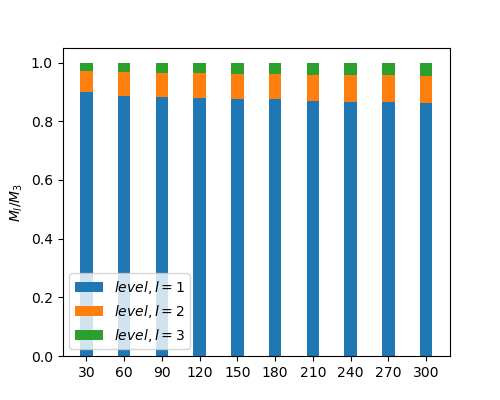

<IPython.core.display.Javascript object>


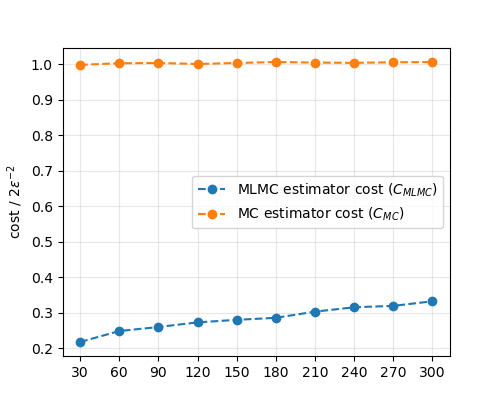

In [6]:
analysis_iter, N_props_mean, N_props_sd = [], [], []
for key in analysis_model.analysis_report.keys():
    analysis_iter.append(int(key[5:]))
    N_ml_proportions = []
    for i in range(2,3):
        N_ml_array = np.array( analysis_model.analysis_report[key]['ml_results']['N_ml'][i] )
        N_ml_proportions.append( N_ml_array/np.sum(N_ml_array) )
    N_props_mean.append(np.mean(N_ml_proportions, axis=0))
    
N_props_mean = np.array(N_props_mean)
    
fig,ax = plt.subplots(1,1,figsize=(5,4))
analysis_frequency = 3
ax.bar(analysis_iter, N_props_mean[:,0], width=10, label=r'$level, l=1$')
ax.bar(analysis_iter, N_props_mean[:,1], width=10, bottom=N_props_mean[:,0], label=r'$level, l=2$')
ax.bar(analysis_iter, N_props_mean[:,2], width=10, bottom=N_props_mean[:,0]+N_props_mean[:,1], label=r'$level, l=3$')
ax.set_ylabel(r'$M_l/M_3$')
ax.legend()
ax.set_xticks(analysis_iter)

fig.savefig(data_dir+'/'+case+'_m_l.pdf')


fig,ax = plt.subplots(1,1,figsize=(5,4))

analysis_iter, cost_mc_eps, cost_ml_eps = [], [], []
for key in analysis_model.analysis_report.keys():
    analysis_iter.append(int(key[5:]))
    cost_mc, cost_ml = [], []
    for i in range(3):
        N_ml_array = np.array( analysis_model.analysis_report[key]['ml_results']['N_ml'][i] )
        C_ml_array = np.array( analysis_model.analysis_report[key]['ml_results']['C_ml'][i] )
        cost_ml.append(np.dot(N_ml_array, C_ml_array))
        
        N_mc_array = np.array( analysis_model.analysis_report[key]['mc_results']['N_mc'][i] )
        C_mc_array = np.array( analysis_model.analysis_report[key]['mc_results']['C_mc'] )
        cost_mc.append(np.dot(N_mc_array, C_mc_array))

    cost_ml_eps.append(cost_ml)
    cost_mc_eps.append(cost_mc)
    
cost_ml_eps = np.array(cost_ml_eps)
cost_mc_eps = np.array(cost_mc_eps)

ax.plot(analysis_iter, 1e-4*0.5*cost_ml_eps[:,2], 'o--', label=r'MLMC estimator cost ($C_{MLMC}$)')
ax.plot(analysis_iter, 1e-4*0.5*cost_mc_eps[:,2], 'o--', label=r'MC estimator cost ($C_{MC}$)')
ax.set_ylabel(r'cost / $2\varepsilon^{-2}$')
ax.legend()
ax.grid('on', alpha=0.3)
ax.set_xticks(analysis_iter)

fig.savefig(data_dir+'/'+case+'_cost_compare.pdf')

# Comparison between MC and MLMC estimator

<IPython.core.display.Javascript object>


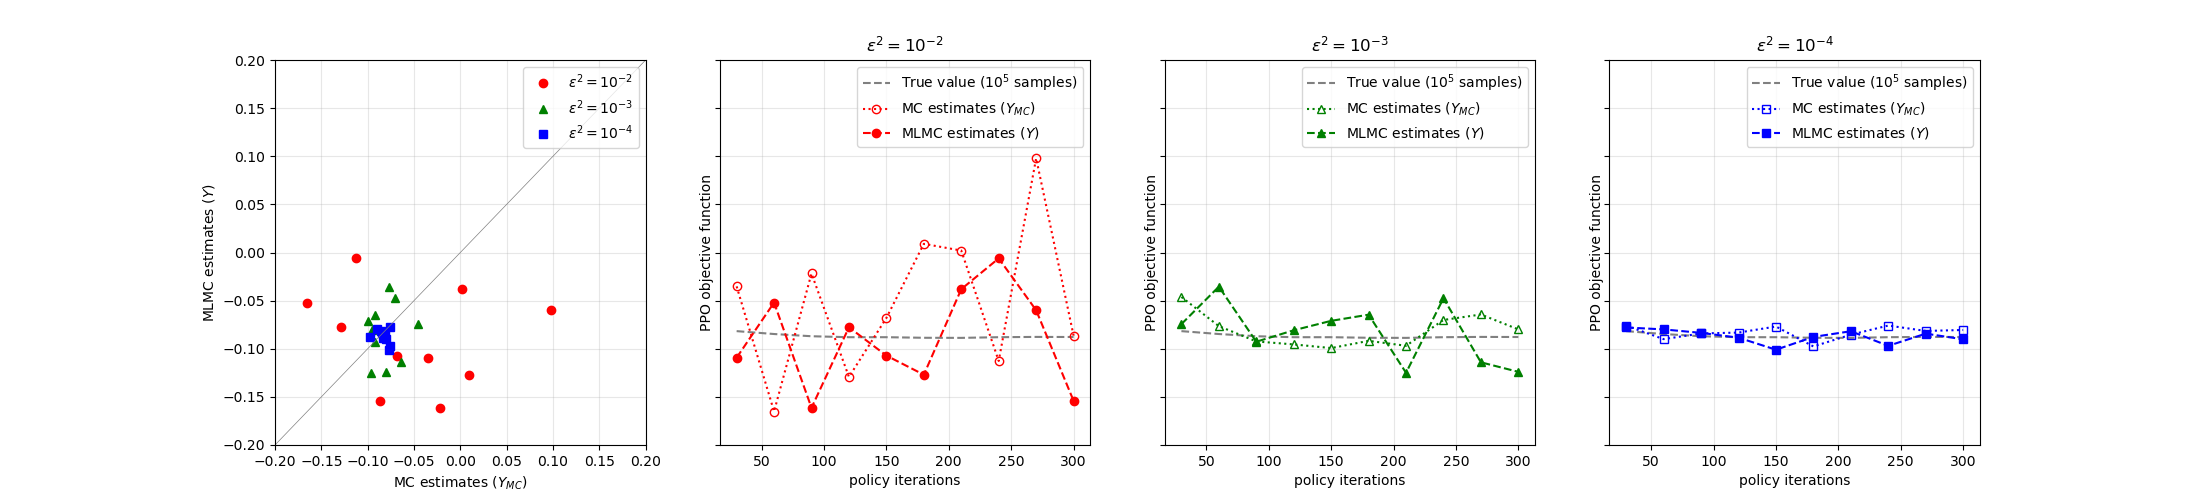

In [7]:
analysis_iter = []

for key in analysis_model.analysis_report.keys():
    analysis_iter.append(int(key[5:]))

P_mc, P_ml, P_l = [], [], []
for key in analysis_model.analysis_report.keys():
    P_mc.append(analysis_model.analysis_report[key]['mc_results']['P_mc'])
    P_ml.append(analysis_model.analysis_report[key]['ml_results']['P_ml'])
    P_l.append(analysis_model.analysis_report[key]['expt_results']['P_l'])

P_mc, P_ml, P_l = np.array(P_mc), np.array(P_ml), np.array(P_l)

fig,ax = plt.subplots(1,4,figsize=(22,5), sharey=True)
ax[0].plot(P_mc[:,0], P_ml[:,0], 'o',label=r'$\epsilon^2=10^{-2}$',color='red')
ax[0].plot(P_mc[:,1], P_ml[:,1], '^',label=r'$\epsilon^2=10^{-3}$',color='green')
ax[0].plot(P_mc[:,2], P_ml[:,2], 's',label=r'$\epsilon^2=10^{-4}$',color='blue')
ax[0].plot([-0.2, 0.2],[-0.2, 0.2], color='gray', linewidth=0.5)
ax[0].legend(loc='upper right')
ax[0].set_xlim(-0.2, 0.2)
ax[0].set_ylim(-0.2, 0.2)
ax[0].set_xlabel('MC estimates ($Y_{MC}$)')
ax[0].set_ylabel('MLMC estimates ($Y$)')
ax[0].grid('on', alpha=0.3)

# fig,ax2 = plt.subplots(1,1,figsize=(8,6))
ax[1].plot(analysis_iter, P_l[:, -1], '--', label=r'True value ($10^5$ samples)', color='gray')
ax[1].plot(analysis_iter, P_mc[:, -3], 'o:', label='MC estimates ($Y_{MC}$)', fillstyle='none', color='red' )
ax[1].plot(analysis_iter, P_ml[:, -3], 'o--', label='MLMC estimates ($Y$)', color='red' )
ax[1].set_xlabel('policy iterations')
ax[1].set_ylabel('PPO objective function')
ax[1].set_ylim(-0.2, 0.2)
ax[1].legend(loc='upper right')
ax[1].set_title(r'$\epsilon^2=10^{-2}$')
ax[1].grid('on', alpha=0.3)

# fig,ax2 = plt.subplots(1,1,figsize=(8,6))
ax[2].plot(analysis_iter, P_l[:, -1], '--', label=r'True value ($10^5$ samples)', color='gray' )
ax[2].plot(analysis_iter, P_mc[:, -2], '^:', label=r'MC estimates ($Y_{MC}$)', fillstyle='none', color='green' )
ax[2].plot(analysis_iter, P_ml[:, -2], '^--', label='MLMC estimates ($Y$)', color='green' )
ax[2].set_ylabel('PPO objective function')
ax[2].set_xlabel('policy iterations')
ax[2].set_ylim(-0.2, 0.2)
ax[2].legend(loc='upper right')
ax[2].set_title(r'$\epsilon^2=10^{-3}$')
ax[2].grid('on', alpha=0.3)

# fig,ax2 = plt.subplots(1,1,figsize=(8,6))
ax[3].plot(analysis_iter, P_l[:, -1], '--', label=r'True value ($10^5$ samples)', color='gray' )
ax[3].plot(analysis_iter, P_mc[:, -1], 's:', label='MC estimates ($Y_{MC}$)', fillstyle='none', color='blue' )
ax[3].plot(analysis_iter, P_ml[:, -1], 's--', label='MLMC estimates ($Y$)', color='blue' )
ax[3].set_xlabel('policy iterations')
ax[3].set_ylabel('PPO objective function')
ax[3].set_ylim(-0.2, 0.2)
ax[3].legend(loc='upper right')
ax[3].set_title(r'$\epsilon^2=10^{-4}$')
ax[3].grid('on', alpha=0.3)

fig.savefig(data_dir+'/'+case+'_mlmc_estimator.pdf')

# M. Giles style analysis plots

iteration:   30


<IPython.core.display.Javascript object>


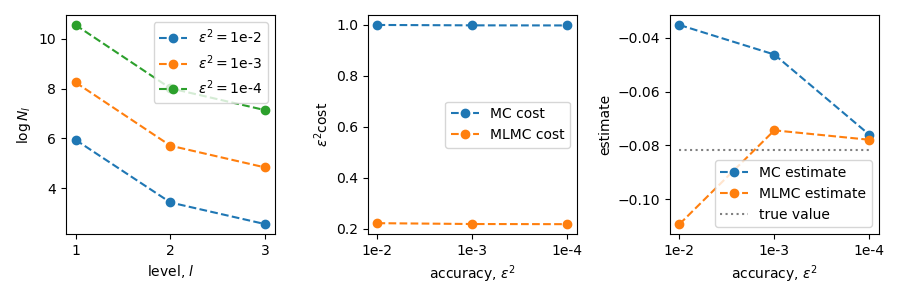

iteration:   60


<IPython.core.display.Javascript object>


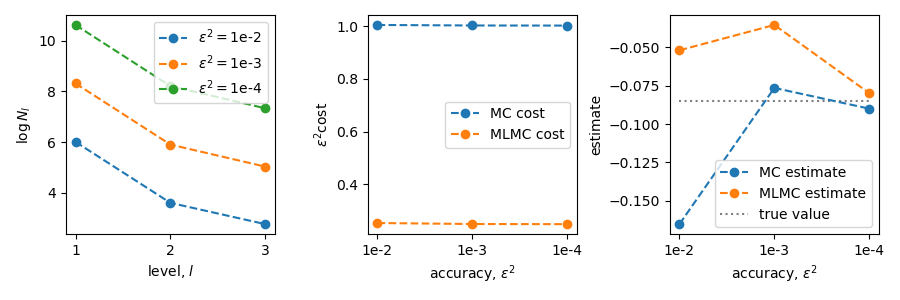

iteration:   90


<IPython.core.display.Javascript object>


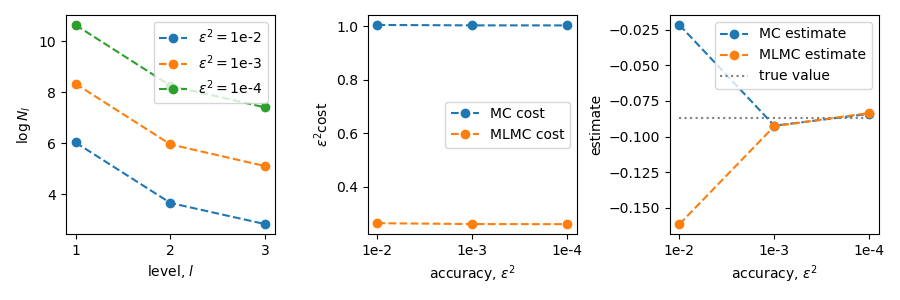

iteration:  120


<IPython.core.display.Javascript object>


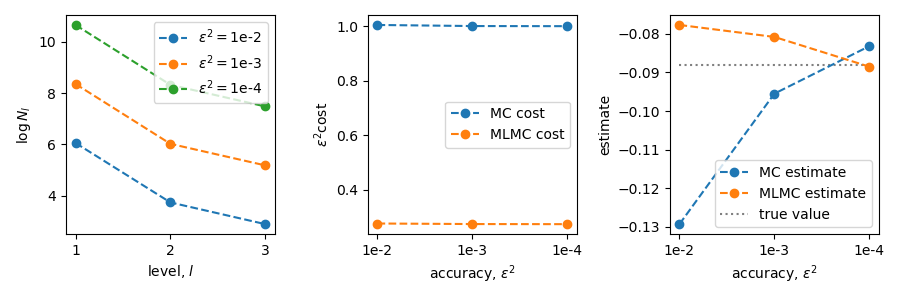

iteration:  150


<IPython.core.display.Javascript object>


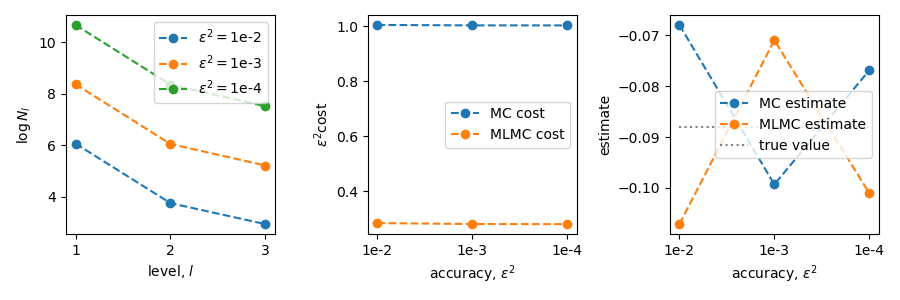

iteration:  180


<IPython.core.display.Javascript object>


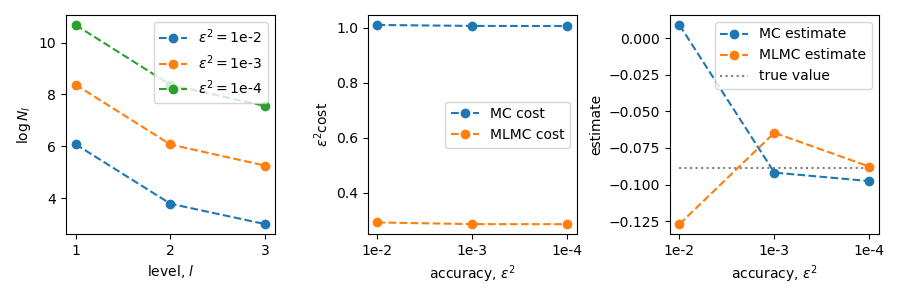

iteration:  210


<IPython.core.display.Javascript object>


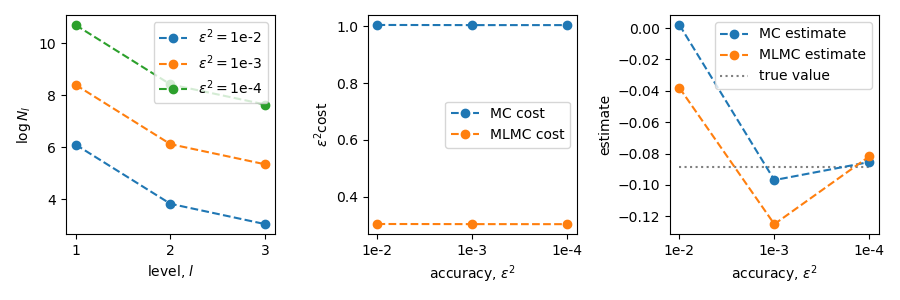

iteration:  240


<IPython.core.display.Javascript object>


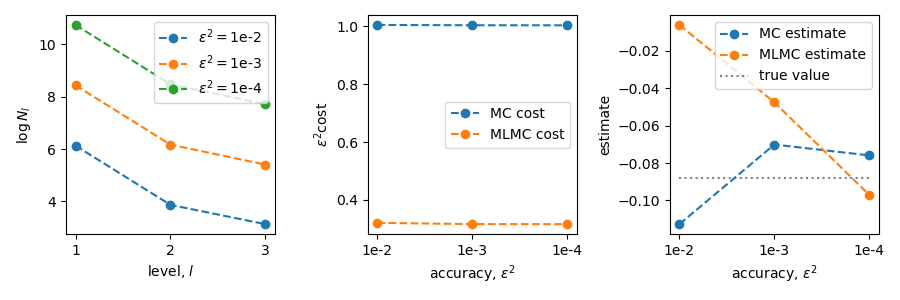

iteration:  270


<IPython.core.display.Javascript object>


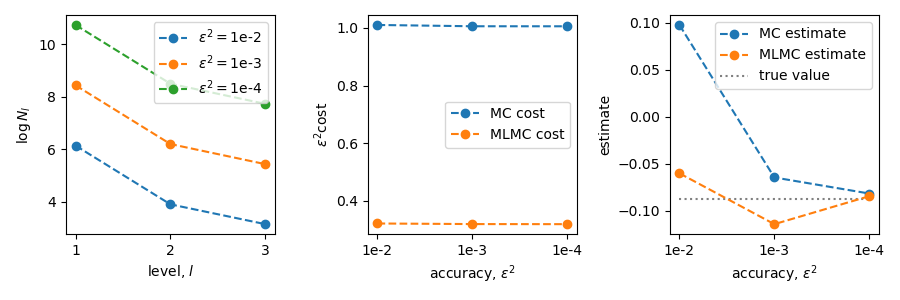

iteration:  300


<IPython.core.display.Javascript object>


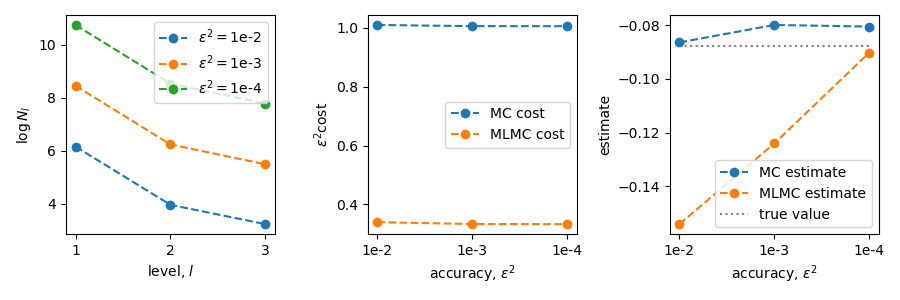

In [8]:
eps = [1e-2, 1e-3, 1e-4]
eps_str = ['1e-2', '1e-3', '1e-4']
l_str = ['1', '2', '3']
key = 'iter 30'
theta = 0.5

for key in analysis_model.analysis_report.keys():
    
    print('iteration: ', key[-3:])

    fig, ax = plt.subplots(1,3,figsize=(9,3))

    # plot number of samples per levels
    N_ml = analysis_model.analysis_report[key]['ml_results']['N_ml']
    for Nl, label in zip(N_ml, eps_str):
        ax[0].plot(l_str, np.log(Nl), 'o--', label=r'$\epsilon^2= $'+label)
    ax[0].legend(framealpha=0.8)
    ax[0].set_xlabel(r'level, $l$')
    ax[0].set_ylabel(r'$\log{N_l}$')
    
    # plot mlmc cost vs mc cost
    N_mc = analysis_model.analysis_report[key]['mc_results']['N_mc']
    C_mc = analysis_model.analysis_report[key]['mc_results']['C_mc']
    C_ml = analysis_model.analysis_report[key]['ml_results']['C_ml']
    std_cost, mlmc_cost = [],[]
    for N, Nl, Cl, ep in zip(N_mc, N_ml, C_ml, eps):
        std_cost.append(N*C_mc*ep*theta)
        mlmc_cost.append(np.dot(Nl,Cl)*ep*theta)
    ax[1].plot(eps_str, std_cost, 'o--', label='MC cost')
    ax[1].plot(eps_str, mlmc_cost, 'o--', label='MLMC cost')
    ax[1].legend(framealpha=0.8)
    ax[1].set_xlabel(r'accuracy, $\epsilon^2$')
    ax[1].set_ylabel(r'$\epsilon^2$cost')

    #plot mlmc estimate vs mc estimate
    P_ml = analysis_model.analysis_report[key]['ml_results']['P_ml']
    P_mc = analysis_model.analysis_report[key]['mc_results']['P_mc']
    P_ref = analysis_model.analysis_report[key]['expt_results']['P_l'][-1]
    ax[2].plot(eps_str, P_mc, 'o--', label='MC estimate')
    ax[2].plot(eps_str, P_ml, 'o--', label='MLMC estimate')
    ax[2].hlines(P_ref, xmin=eps_str[0], xmax=eps_str[-1], linestyle=':', color='gray', label='true value')
    ax[2].legend(framealpha=0.8)
    ax[2].set_xlabel(r'accuracy, $\epsilon^2$')
    ax[2].set_ylabel('estimate')

    fig.tight_layout() 
    fig.show()

# Learning plots

<IPython.core.display.Javascript object>


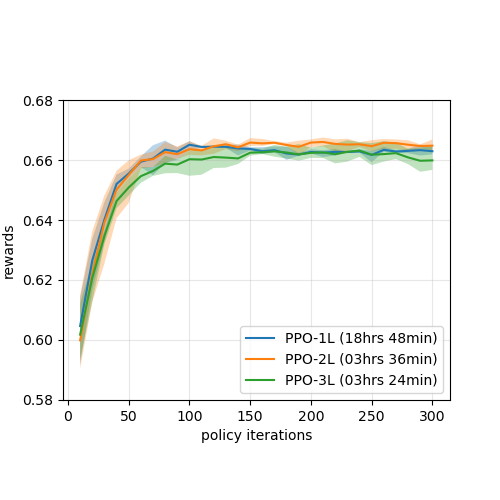

In [9]:
# Learning plot data
_, r_ppo_1l = get_mean_tr_data(ppo_1l_dir, seeds=[1,2,3], result_type='eval', episode_len=5)
_, r_ppo_2l = get_mean_tr_data(ppo_2l_dir, seeds=[1,2,3], result_type='eval', episode_len=5)
_, r_ppo_3l = get_mean_tr_data(ppo_3l_dir, seeds=[1,2,3], result_type='eval', episode_len=5)

_, r_ppo_1l_min = get_min_tr_data(ppo_1l_dir, seeds=[1,2,3], result_type='eval', episode_len=5)
_, r_ppo_2l_min = get_min_tr_data(ppo_2l_dir, seeds=[1,2,3], result_type='eval', episode_len=5)
_, r_ppo_3l_min = get_min_tr_data(ppo_3l_dir, seeds=[1,2,3], result_type='eval', episode_len=5)

_, r_ppo_1l_max = get_max_tr_data(ppo_1l_dir, seeds=[1,2,3], result_type='eval', episode_len=5)
_, r_ppo_2l_max = get_max_tr_data(ppo_2l_dir, seeds=[1,2,3], result_type='eval', episode_len=5)
_, r_ppo_3l_max = get_max_tr_data(ppo_3l_dir, seeds=[1,2,3], result_type='eval', episode_len=5)

# get de benchmark value
opt_array=[]
for i in range(16):
    opt_array.append(np.load(opt_dir+'/ck_max_'+str(i)+'.npy'))

fig, ax = plt.subplots(1,1,figsize=(5,5), sharey=True)
plt.subplots_adjust( bottom=0.2, top=0.8, wspace=None, hspace=None)

p_iter = np.arange(10,310,10)
ax.plot(p_iter, r_ppo_1l, label='PPO-1L (18hrs 48min)')
ax.fill_between(p_iter, r_ppo_1l_min, r_ppo_1l_max, alpha=0.3)
ax.plot(p_iter, r_ppo_2l, label='PPO-2L (03hrs 36min)')
ax.fill_between(p_iter, r_ppo_2l_min, r_ppo_2l_max, alpha=0.3)
ax.plot(p_iter, r_ppo_3l, label='PPO-3L (03hrs 24min)')
ax.fill_between(p_iter, r_ppo_3l_min, r_ppo_3l_max, alpha=0.3)
ax.set_xlabel('policy iterations')
ax.set_ylabel('rewards')
ax.set_ylim([0.58,0.68])
ax.grid('on', alpha=0.3)
ax.legend()
fig.savefig(data_dir+'/'+case+'_r_plot.pdf')

# Training and Evalutation Permeabilities

<IPython.core.display.Javascript object>


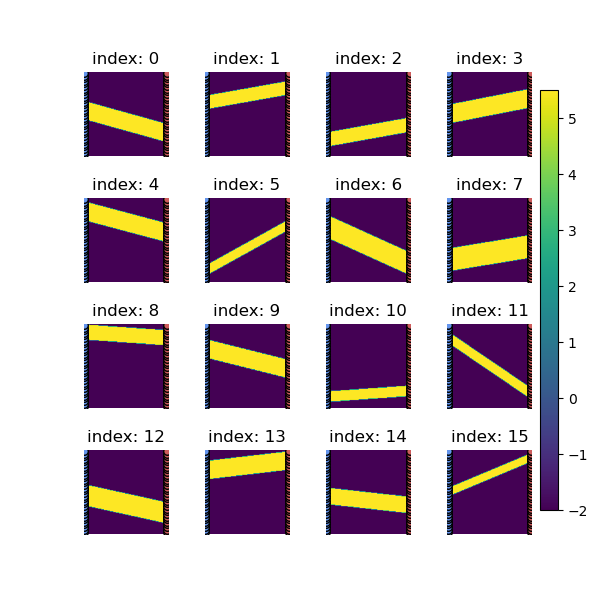

In [10]:
with open('../envs_params/env_data_v1/env_train_dict.pkl', 'rb') as input:
    env_train_dict = pickle.load(input)
fine_level = list(env_train_dict.keys())[-1]
env_train = env_train_dict[fine_level]
k_train = np.load('../envs_params/env_data_v1/k_log_md_train_clustered.npy')
fig = plot_k_array(k_train, env_train.ressim_params.q.copy(), rows=4, cols=4, marker_size=30)
fig.savefig(data_dir+'/'+case+'_k_train.pdf')

<IPython.core.display.Javascript object>


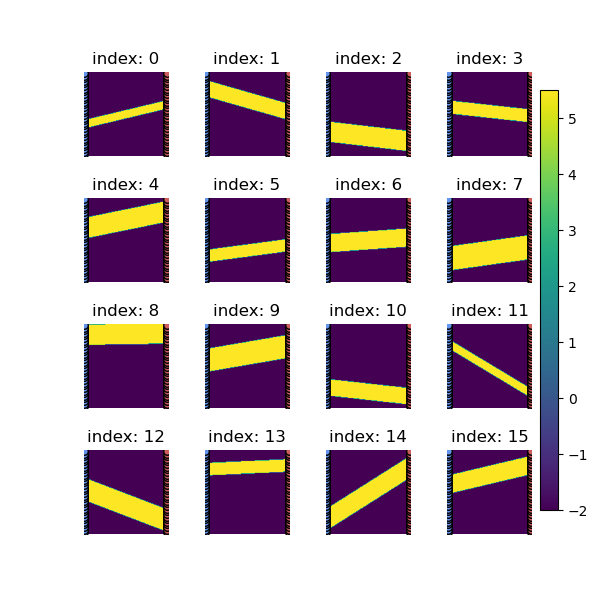

In [11]:
k_eval = np.load('../envs_params/env_data_v1/k_log_md_eval_clustered.npy')
fig = plot_k_array(k_eval, env_train.ressim_params.q.copy(), rows=4, cols=4, marker_size=30)
fig.savefig(data_dir+'/'+case+'_k_eval.pdf')

# Plot results

In [12]:
# data gathering
seed=3
model_ppo_1l = PPO.load(ppo_1l_dir+'/seed_'+str(seed)+'/best_model/best_model')
model_ppo_2l = PPO.load(ppo_2l_dir+'/seed_'+str(seed)+'/best_model/best_model')
model_ppo_3l = PPO.load(ppo_3l_dir+'/seed_'+str(seed)+'/best_model/best_model')

with open('../envs_params/env_data_v1/env_eval_dict.pkl', 'rb') as input:
    env_eval_dict = pickle.load(input)
env_eval = env_eval_dict[fine_level]

k_list = env_eval.ressim_params.k_list
envs = []
for k in k_list:
    env_ = deepcopy(env_train)
    env_.set_k(np.array([k]))
    envs.append(env_)
    
models=[model_ppo_1l, model_ppo_2l, model_ppo_3l]
model_names = ['PPO-1L', 'PPO-2L', 'PPO-3L']

s_array_eval, a_array_eval, r_array_eval, case_names_eval = get_sar_data(envs, list(range(16)),
                                                                         opt_dir,
                                                                         models, model_names, model_base_steps = 0)

/data/ad181/RemoteDir/multilevel_ppo/stable_baselines_mlppo/stable_baselines3/common/envs/multi_level_model/level_mapping_functions.py:51: NumbaExperimentalFeatureWarning: First-class function type feature is experimental
  for j in range(len(p_1)-1):


<IPython.core.display.Javascript object>


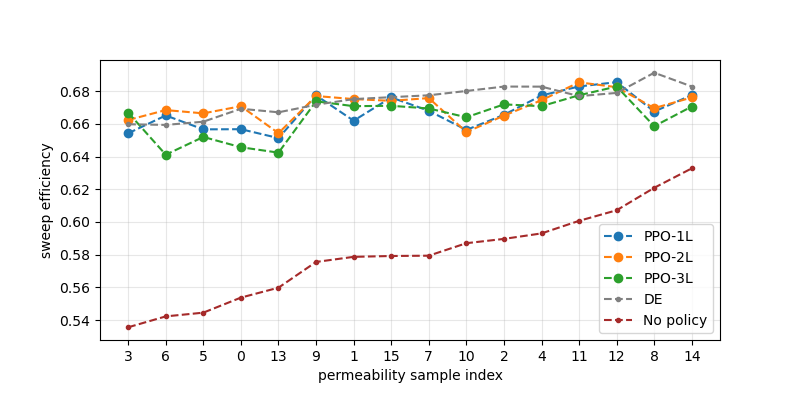

In [13]:
# plot rewards (oil recovery)
fig, axs = plt.subplots(1,1,figsize=(8,4))
plt.subplots_adjust(left=None,bottom=0.15,right=None,top=0.85,wspace=0.1,hspace=0.1)
plot_rewards(r_array_eval, axs, model_names)
axs.grid('on', alpha=0.3)
fig.savefig(data_dir+'/'+case+'_r_eval.pdf')

<IPython.core.display.Javascript object>


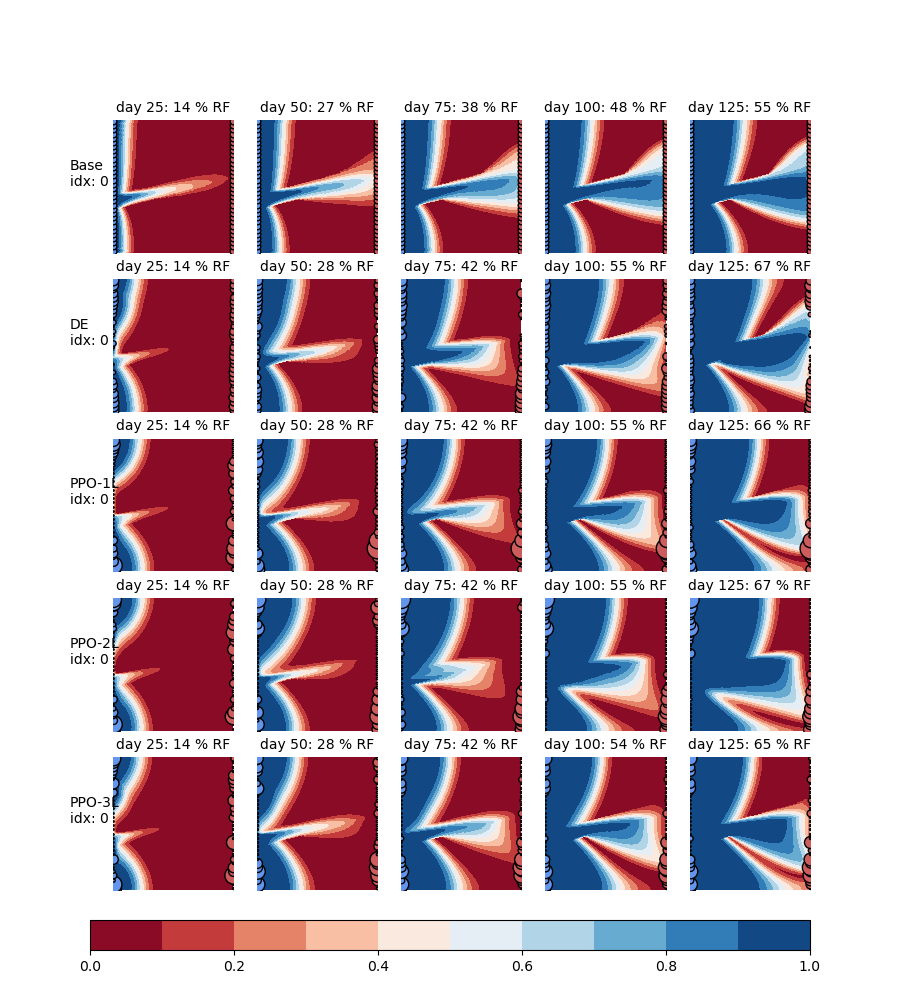

<IPython.core.display.Javascript object>


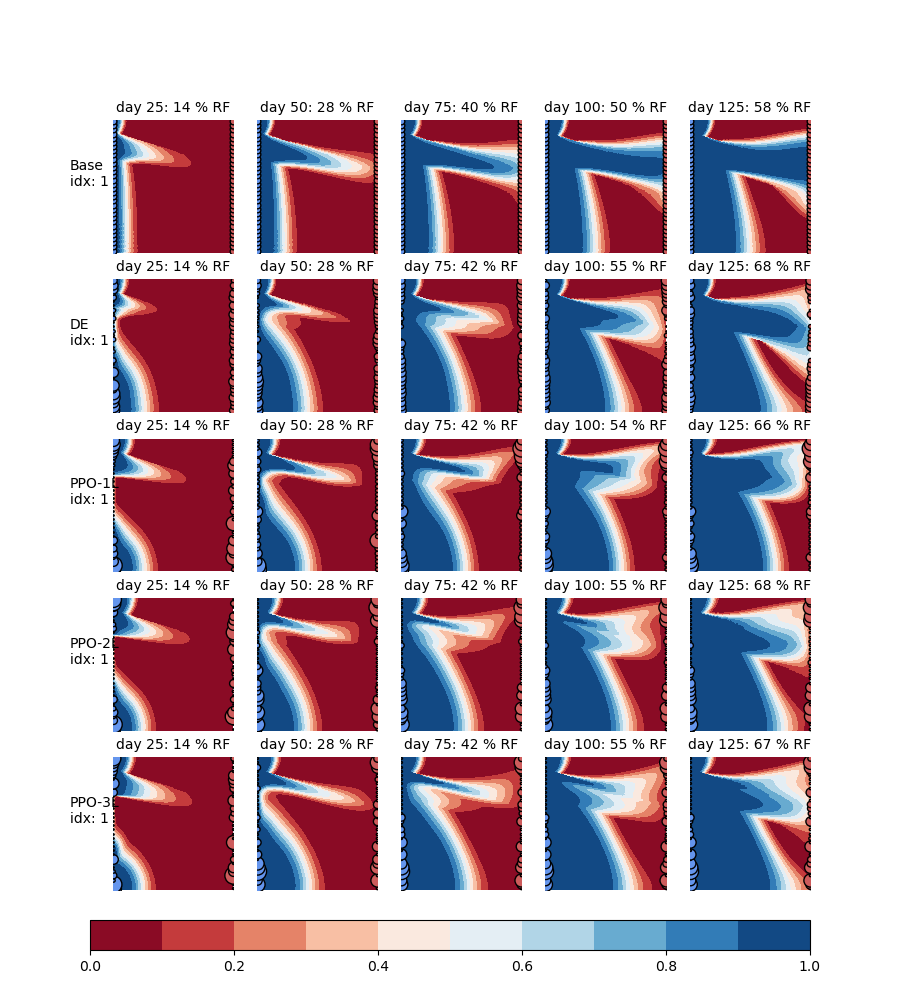

<IPython.core.display.Javascript object>


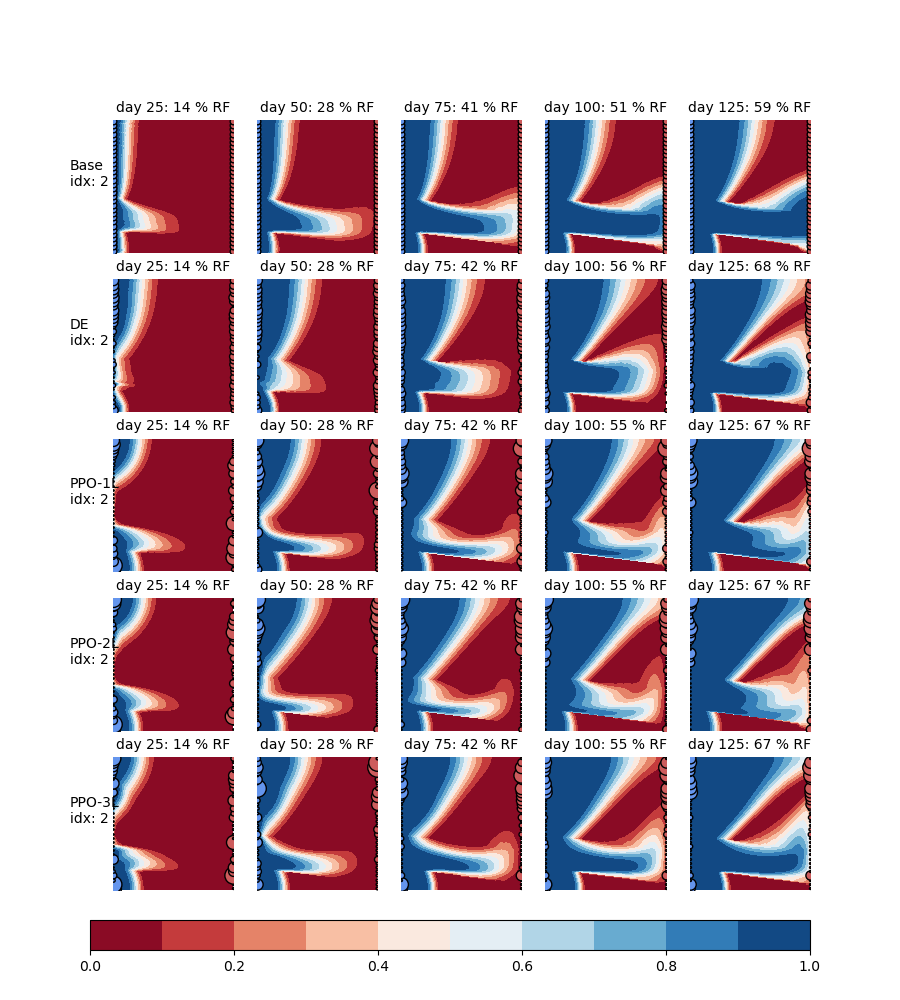

/data/ad181/RemoteDir/multilevel_ppo/utils/plot_functions.py:274: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(cases,steps, figsize=(9,2*cases), sharex=True)


<IPython.core.display.Javascript object>


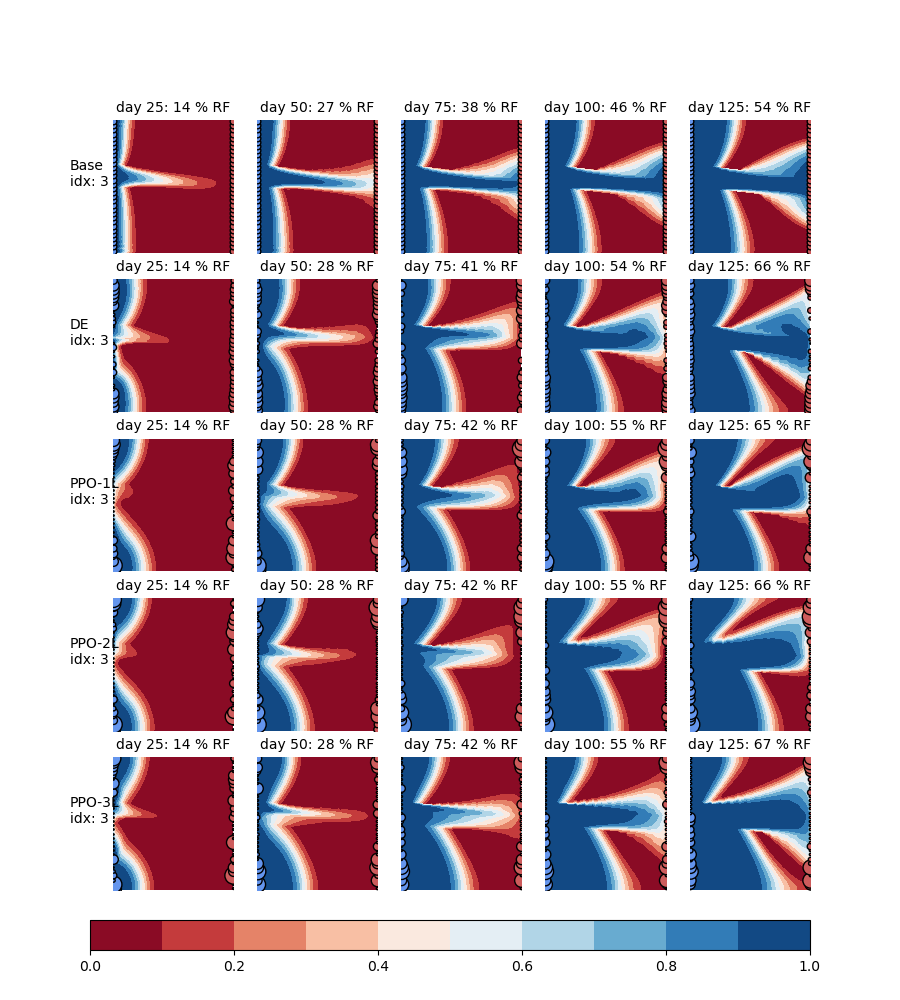

<IPython.core.display.Javascript object>


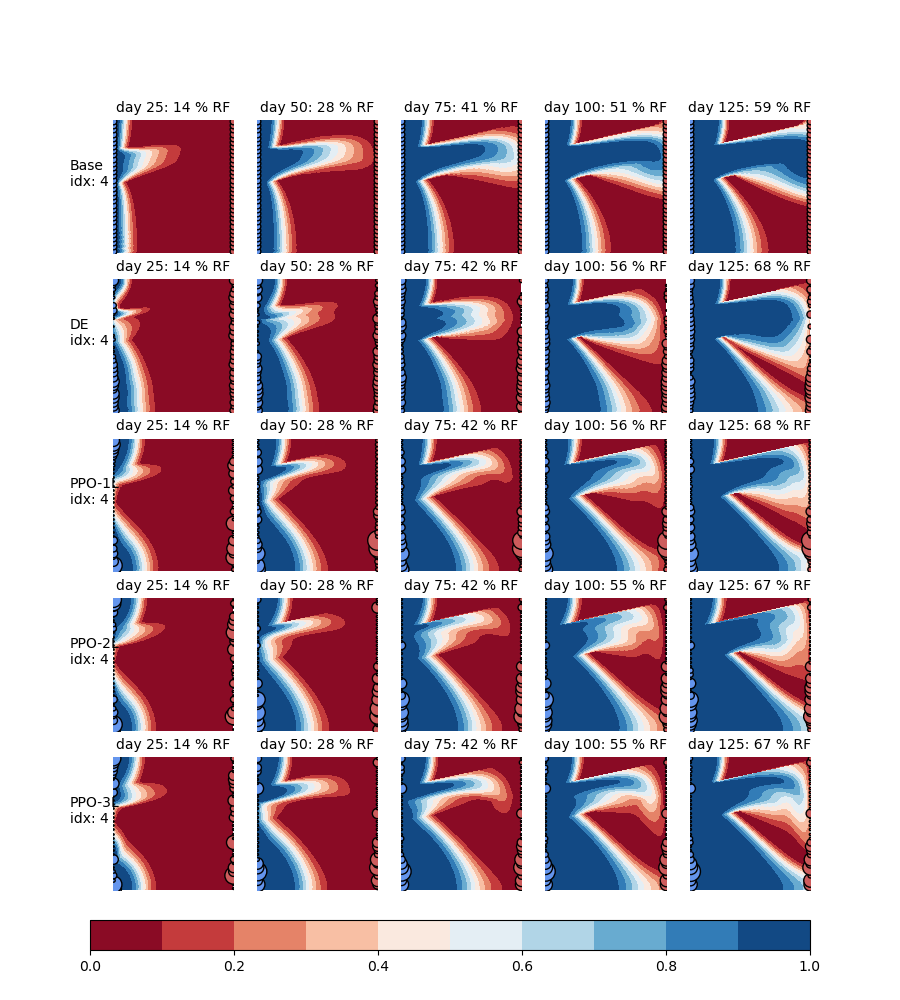

<IPython.core.display.Javascript object>


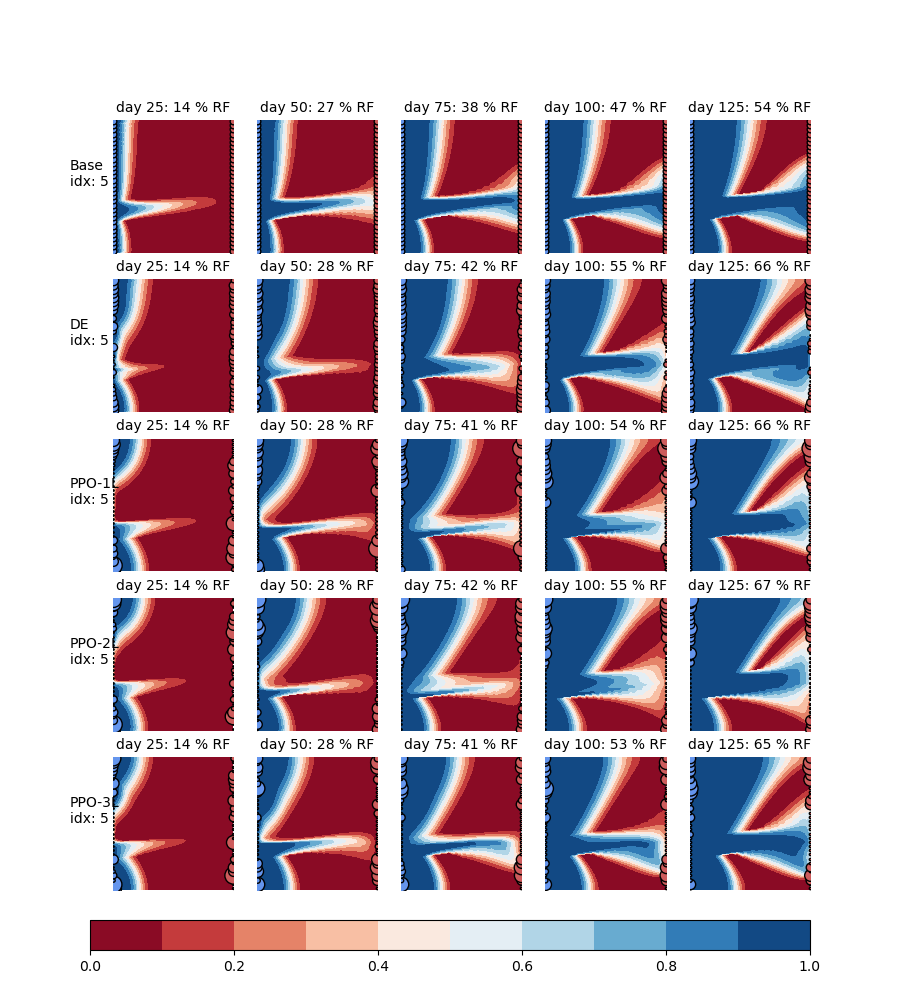

<IPython.core.display.Javascript object>


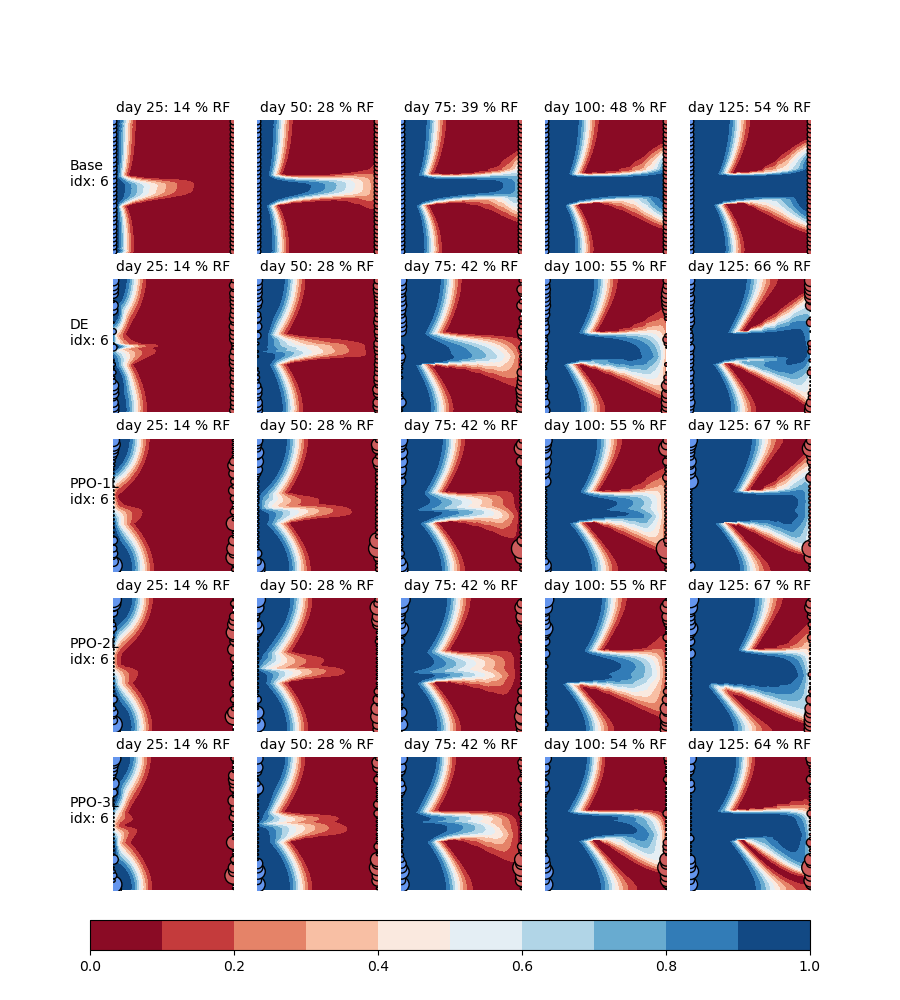

<IPython.core.display.Javascript object>


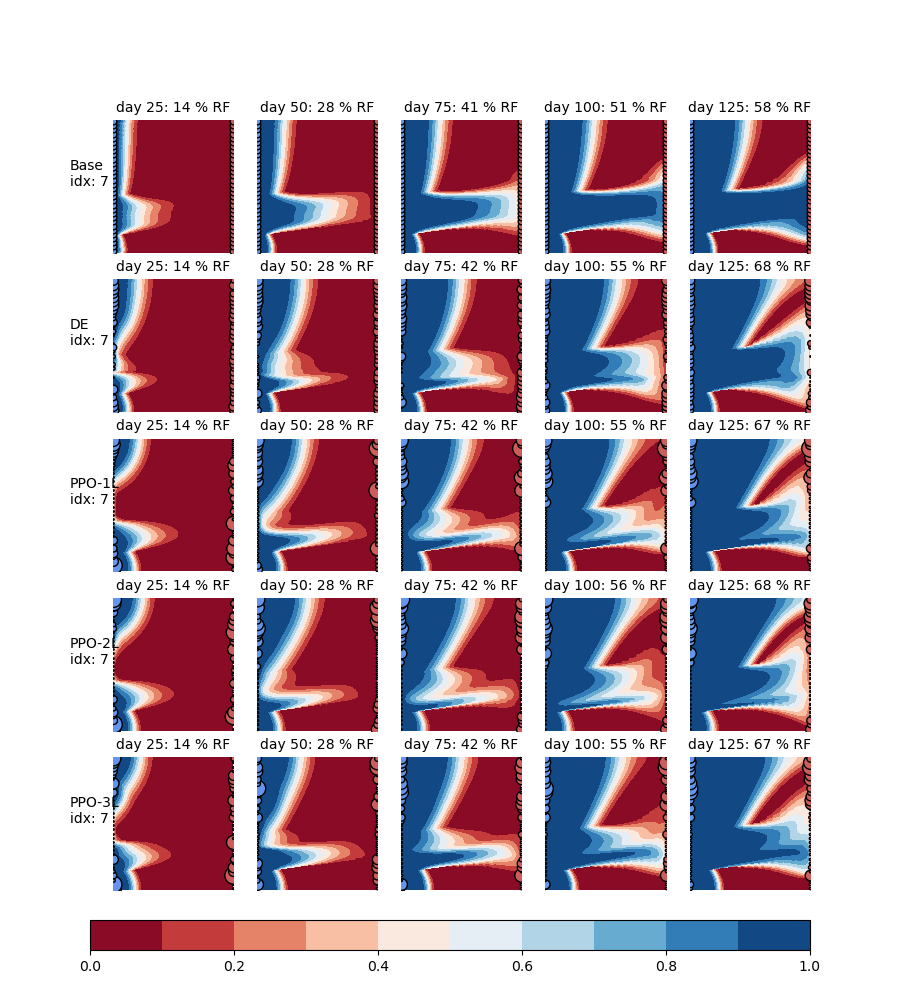

<IPython.core.display.Javascript object>


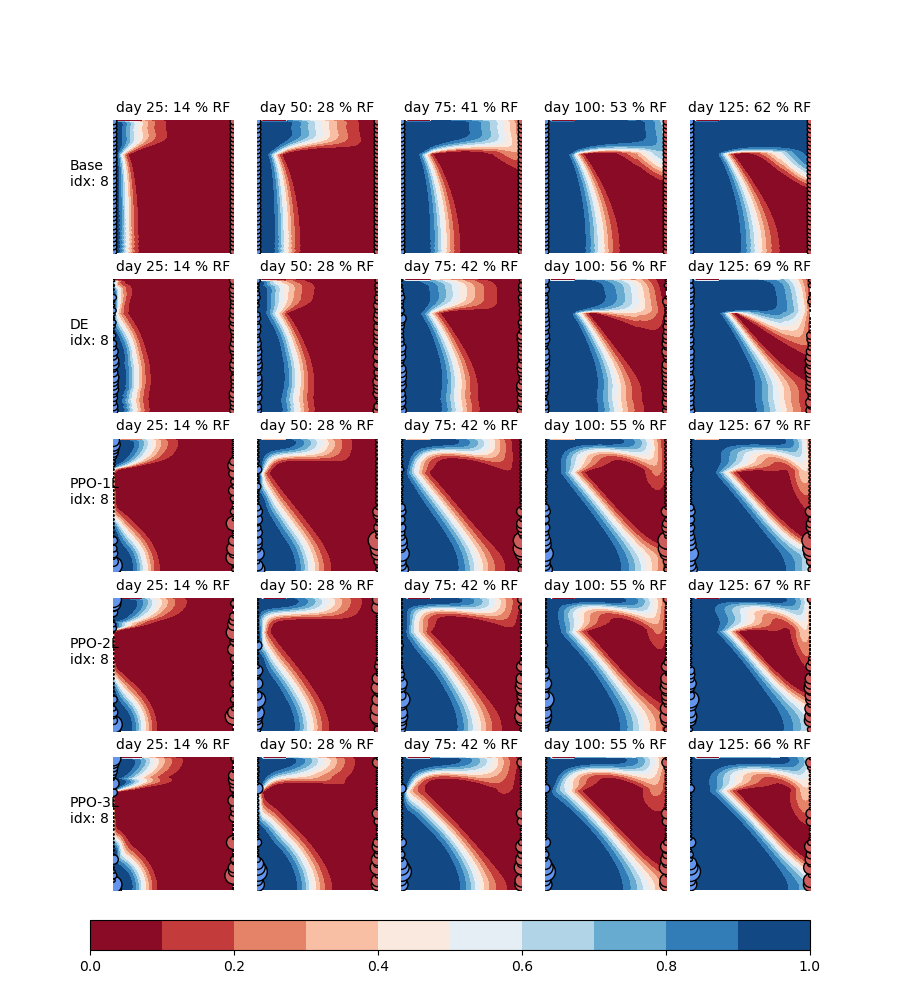

<IPython.core.display.Javascript object>


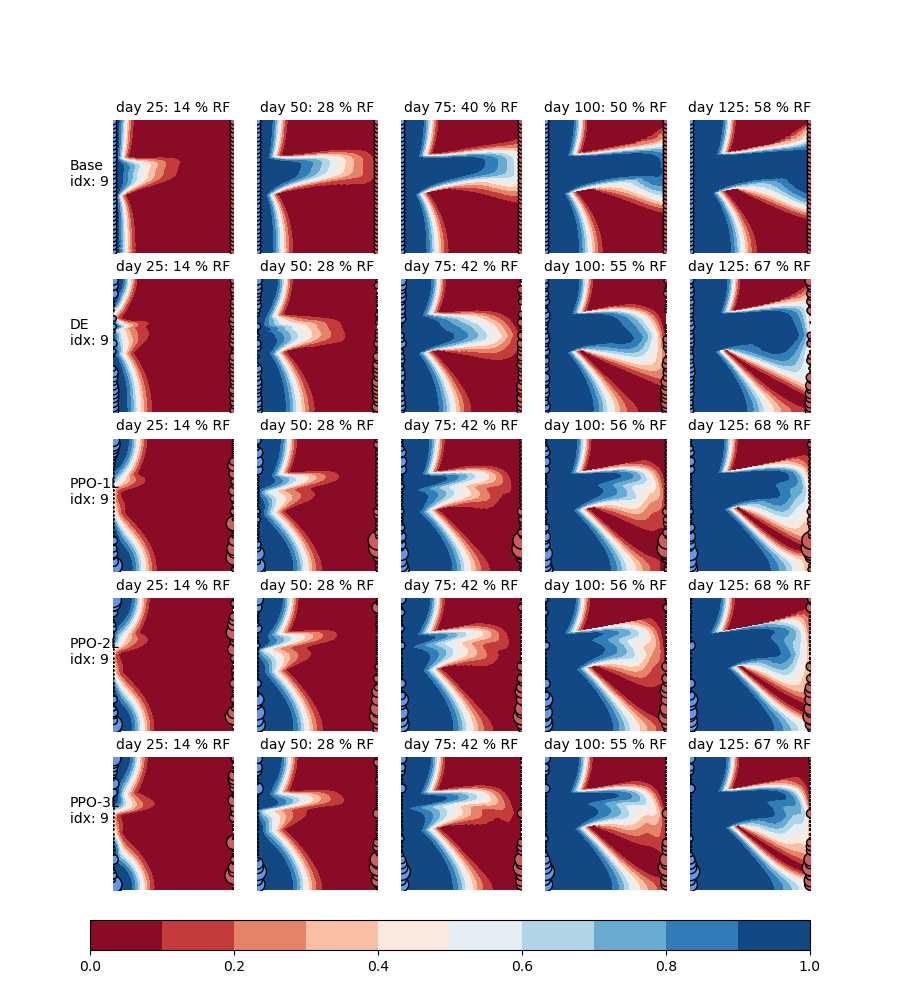

<IPython.core.display.Javascript object>


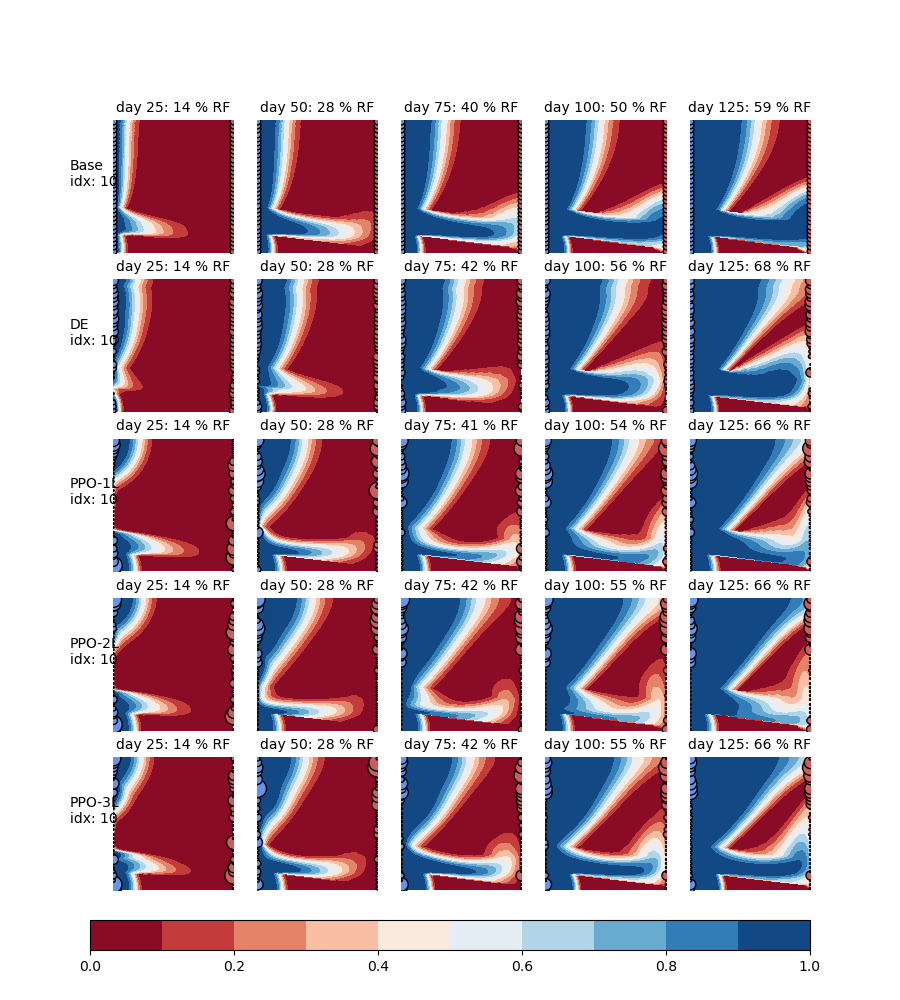

<IPython.core.display.Javascript object>


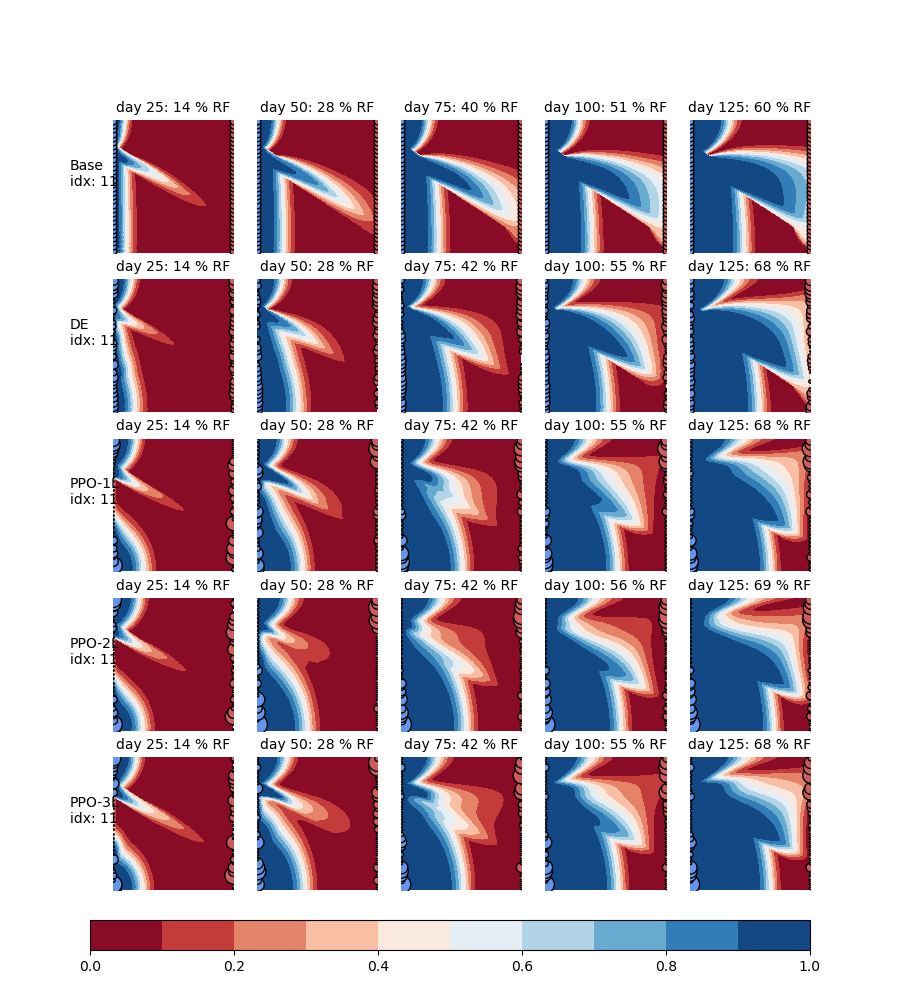

<IPython.core.display.Javascript object>


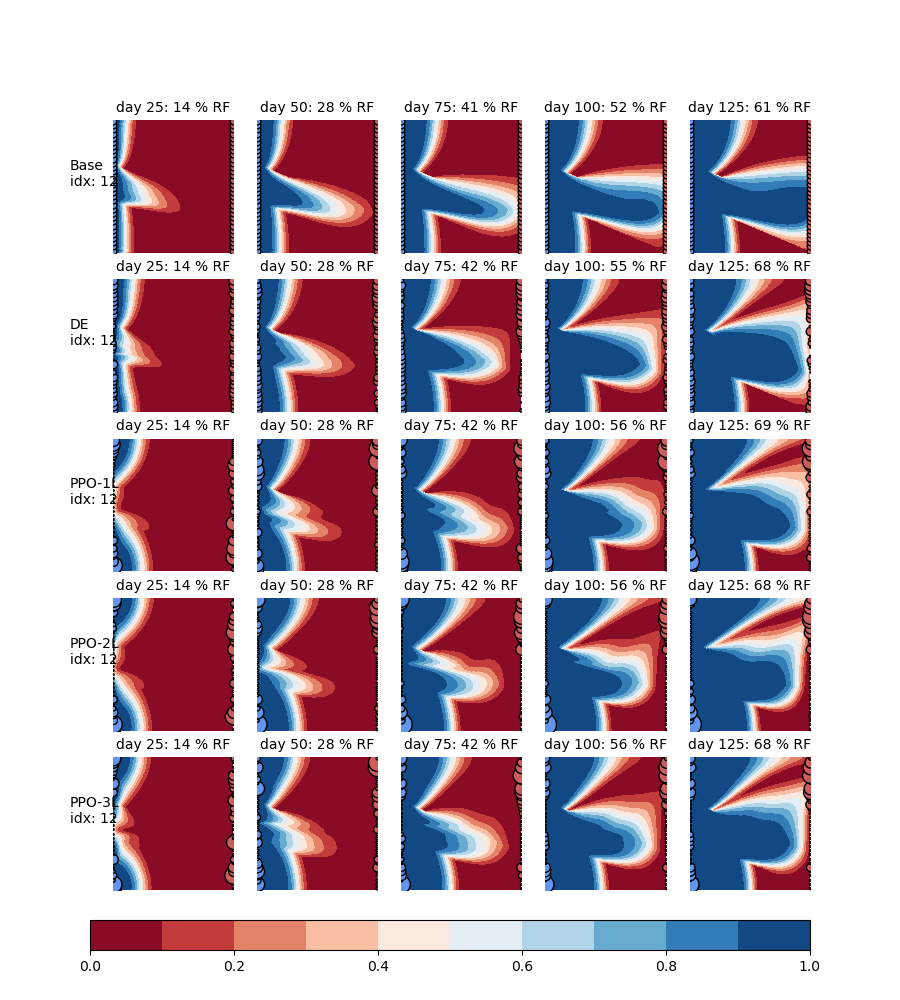

<IPython.core.display.Javascript object>


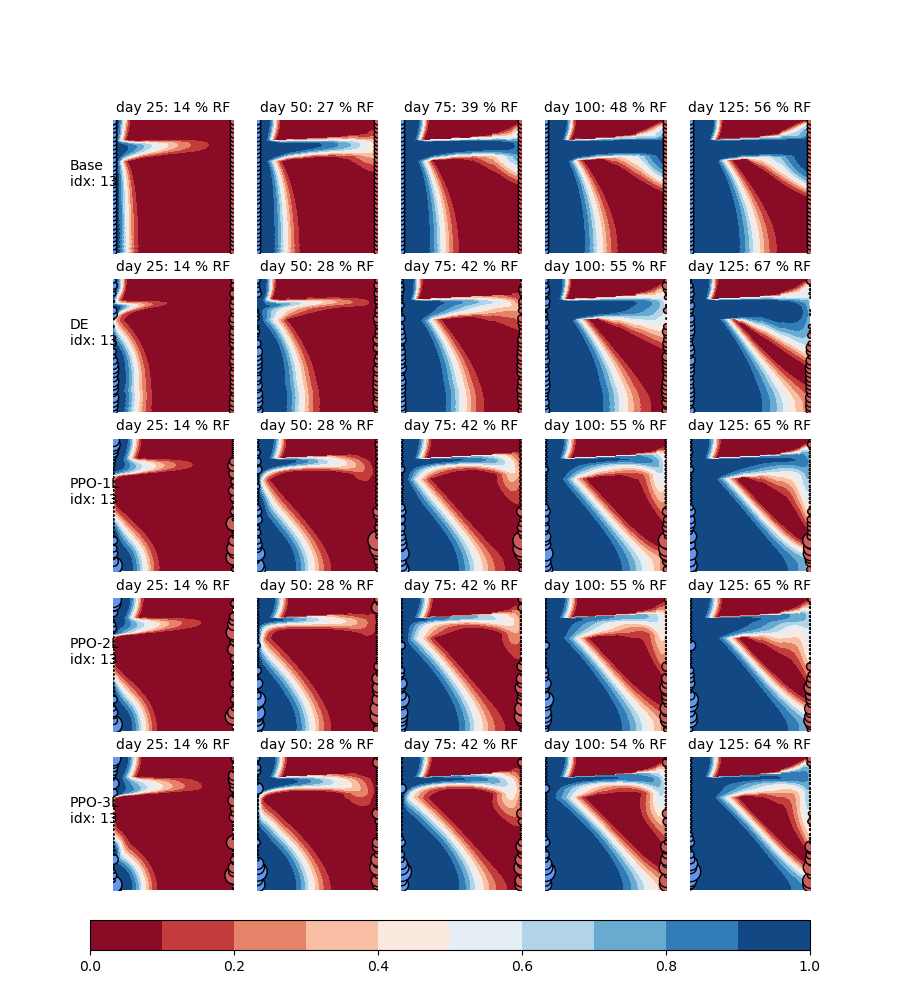

<IPython.core.display.Javascript object>


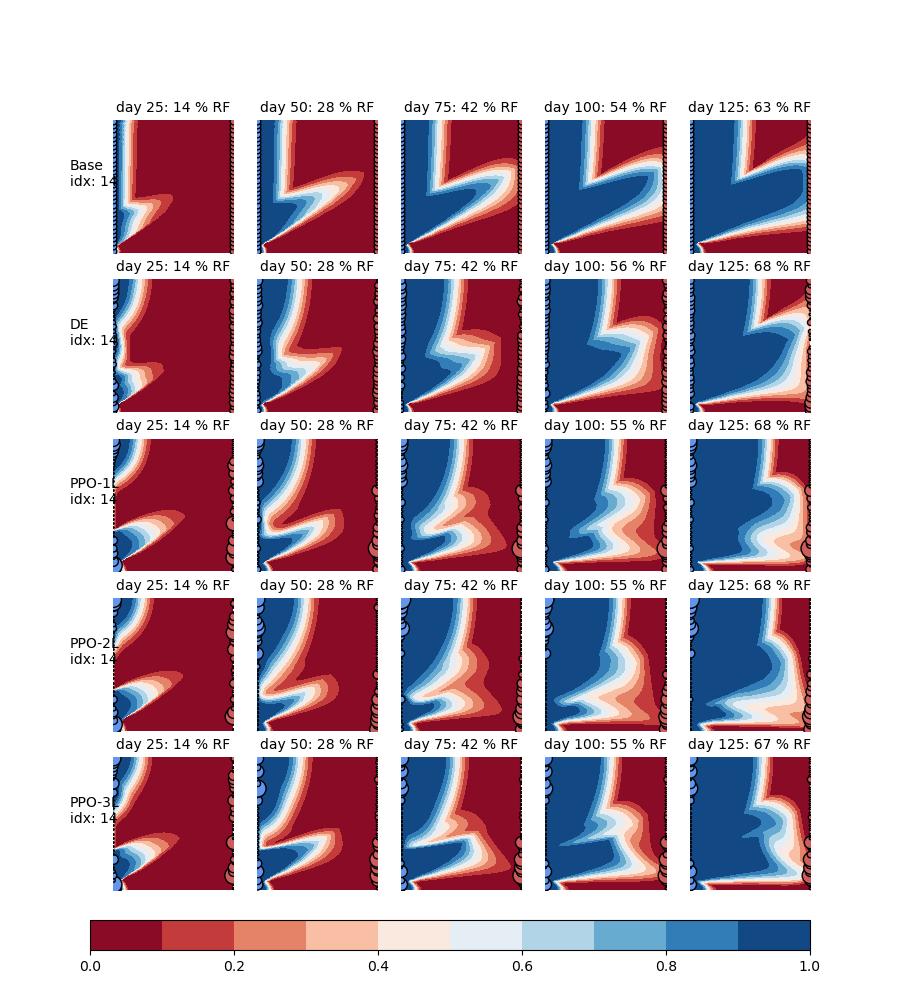

<IPython.core.display.Javascript object>


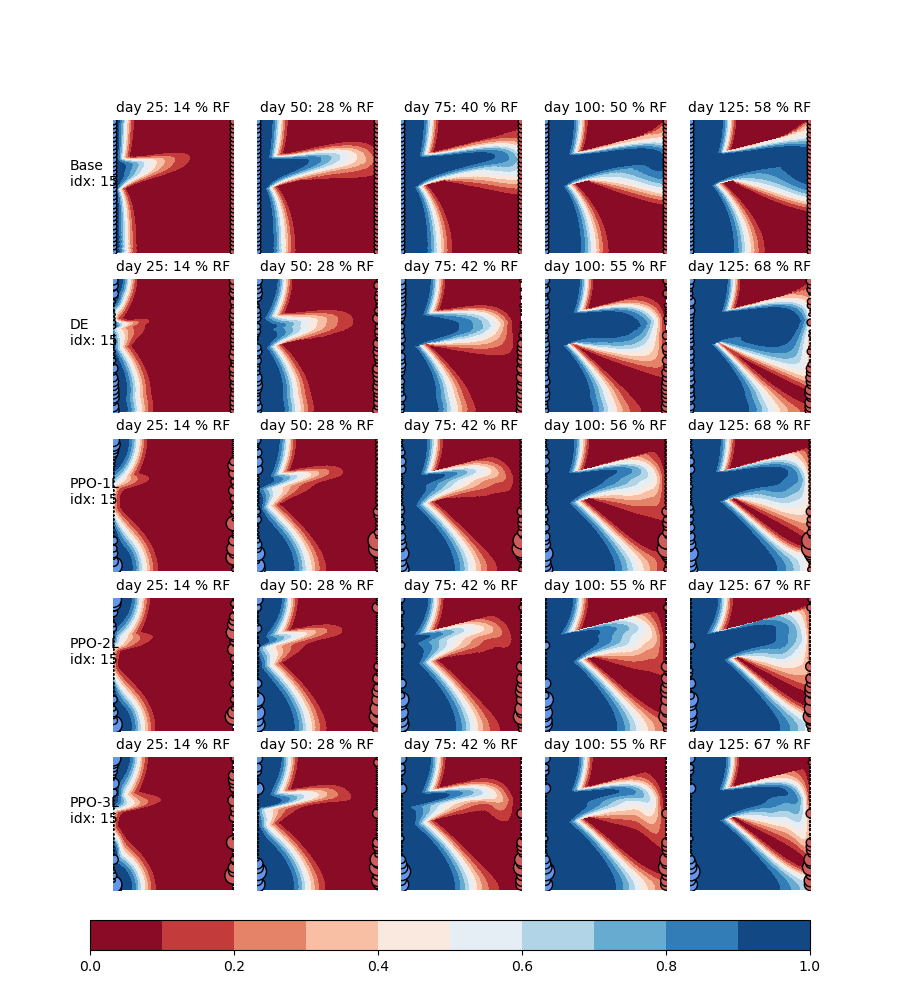

In [14]:
# plot actions (well schedules)
for i,(r_array, a_array, s_array, case_names) in enumerate(zip(r_array_eval, a_array_eval, s_array_eval, case_names_eval)):
    fig = plot_actions(r_array, a_array, s_array, case_names,
                 s_min=0, s_max=1, 
                 levels=10, show_wells=True, marker_size_ref=5,
                 time_per_step=25, time_unit='day')
    fig.savefig(data_dir+'/'+case+'_a_eval_'+str(i)+'.pdf')